# Convert embeddings to sqlite

In [4]:
from gensim.models import KeyedVectors
from gensim import models
from IPython.display import Markdown
import pandas as pd
import os

In [28]:
import dhlab.graph_networkx_louvain as gnl
import networkx as nx

from collections import Counter

In [53]:
model_file = "/mnt/disk2/norn/embeddings/digibok_1850-1900.txt.model"

In [54]:
model = KeyedVectors.load(model_file)    #load_word2vec_format(model_file, binary=True)
d = model.wv
del model

In [73]:
d.most_similar('Jesus',topn= 40)

[('Frelseren', 0.9118380546569824),
 ('Kristus', 0.888516902923584),
 ('Christus', 0.8663530945777893),
 ('Herren', 0.8487850427627563),
 ('Jefus', 0.8341578245162964),
 ('Jesns', 0.8229101896286011),
 ('Jesum', 0.801689088344574),
 ('Gud', 0.7950313687324524),
 ('Frelser', 0.7639067769050598),
 ('Fesus', 0.7537464499473572),
 ('sesus', 0.7442950010299683),
 ('Moses', 0.7315504550933838),
 ('Ham', 0.7313745021820068),
 ('Paulus', 0.726498544216156),
 ('esus', 0.7184481620788574),
 ('Petrus', 0.7156994938850403),
 ('Helligaand', 0.7126523852348328),
 ('Christum', 0.7065466046333313),
 ('Messias', 0.6980326175689697),
 ('Jesu', 0.6972025632858276),
 ('lesns', 0.6961865425109863),
 ('Hellig-Aand', 0.6958786249160767),
 ('Pilatus', 0.6936099529266357),
 ('David', 0.6906453967094421),
 ('Abraham', 0.6897819638252258),
 ('Engelen', 0.6887949705123901),
 ('Jesnus', 0.6887149214744568),
 ('Aanden', 0.6882373690605164),
 ('Israel', 0.6874371767044067),
 ('Faderen', 0.6845176219940186),
 ('FJesu

In [74]:
T = ""
for x in "Himlen Havet Sjøen Øine Haand Aand".split():
    try:
        text = f"### {x} \n {', '.join([x[0] for x in d.most_similar(x, topn=15)])}\n\n"
    except:
        text = f"### {x} \n"
    T += text
    
Markdown(T)
    

### Himlen 
 Himmelen, Skyen, Skyerne, Jorden, Himmel, Ham, Solen, Mørket, Himlene, Lyset, Himlens, Evigheden, Høie, Dybet, Helvede

### Havet 
 Søen, Oceanet, Verdenshavet, Vandet, Bølgerne, Dybet, Bjergene, Sjøen, Floden, Klipperne, Vandene, Kysten, Havfladen, Bjærgene, Sletten

### Sjøen 
 Søen, Isen, Fjorden, Revet, Fjæren, Tjernet, Elven, Stranden, Sjøerne, Fjeldet, Fossen, Skjærene, Baaden, Soen, Havet

### Øine 
 Øjne, Oine, Ojne, Qine, Ansigt, Blikke, ØQine, ØPjne, Aasyn, Øino, Øjno, ØOine, Øren, Ansigter, Ojns

### Haand 
 Arm, Finger, Haaud, Mund, Hænder, Skulder, Hånd, Hagnd, Tommelfinger, Pegefinger, Næve, Arme, Haanden, Albue, Hæl

### Aand 
 Kraft, Sjæl, Tro, Aanden, Sjel, Gjerning, Vilje, Åand, Villie, Kjærlighed, Lære, Fylde, Aaud, Krast, Natur



In [29]:
def make_edges(w, topn=20, visited=None, model = d, level = 0):
    edges = []
    if w not in visited:
        visited.append(w)
        try:
            gdata =  model.most_similar(w, topn=topn)
            edges += [(w, g[0], g[1]) for g in gdata]
            #print(visited)
            if level > 0:
                for g in gdata:
                    l = level - 1
                    edges += make_edges(g[0], topn=topn, visited = visited, level=l)
                    #print(l,edge)
        except:
            pass
            #print("problem", w)
    return edges

def graf(w, model = d, top = 20):
    edges = make_edges(w, topn = top, visited=[], model=model,level = 1)
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    return G

def show_centralities(G, size=10):
    cols = [Counter(nx.betweenness_centrality(G)).most_common(size),
            Counter(nx.degree_centrality(G)).most_common(size),
            Counter(nx.in_degree_centrality(G)).most_common(size),
            Counter(nx.out_degree_centrality(G)).most_common(size)
           ]
    names = ["Betweennes", "Degree", "Indegree", "Outdegree"]
    res = zip(names, cols)
    cents = pd.concat(map(lambda x: pd.DataFrame(x[1], columns =['index', x[0]]).set_index('index'), res), axis = 1)
    return cents

In [82]:
G = graf('Industri',model=d, top=15)

gnl.show_communities(G)

Industri-lndustri :  Industri, lndustri, Indusiri, Indaustri

Agerdyrkning-Frugtavl :  Agerdyrkning, Frugtavl, Qvægavl, Faareavl, Fædrivt, Kvægavl, Jorddyrkning, Skovdrift, Biavl, Ovægavl, Havedyrkning, Agerbrug, OQvægavl, Kvæg-, Høravl, Fuglefangst, Fædrift, Engjord, Avægavl, Fæedrift

Bergværksdrift-Fabrikvirksomhed :  Bergværksdrift, Fabrikvirksomhed, Fabrikdrift, Fabrik-, Haandværks-, Bjergværksdriften, Haandværksdrift, Manufactur-, Øandel, Landbruget, Haandværker, Agricultur, Forstvæsenet, Industrie-, Haandverker, Manufaktur-, Kunst-, Bjergverksdrift, Fabrikog, Qvæghandel, Fabrikflid, Haandværk-, Fabrik, Fabrikvæsenet, Fabrikker, Fabrik-og, Bergværker

Kornhandel-Bjergværksdrift :  Kornhandel, Bjergværksdrift, Trælasthandelen, Trælasthandel, Mellemhandel, Søehandel, Søhandelen, Fædriften, Fragthandel, Næringsgreen, Jerntilvirkning, Handelstad

Skibsfart-Kunstflid :  Skibsfart, Kunstflid, Handel, Industrie, Søfart, Søhandel, Landhandel, Konstflid, Huusflid, Søefart, Fragtfart, Viin

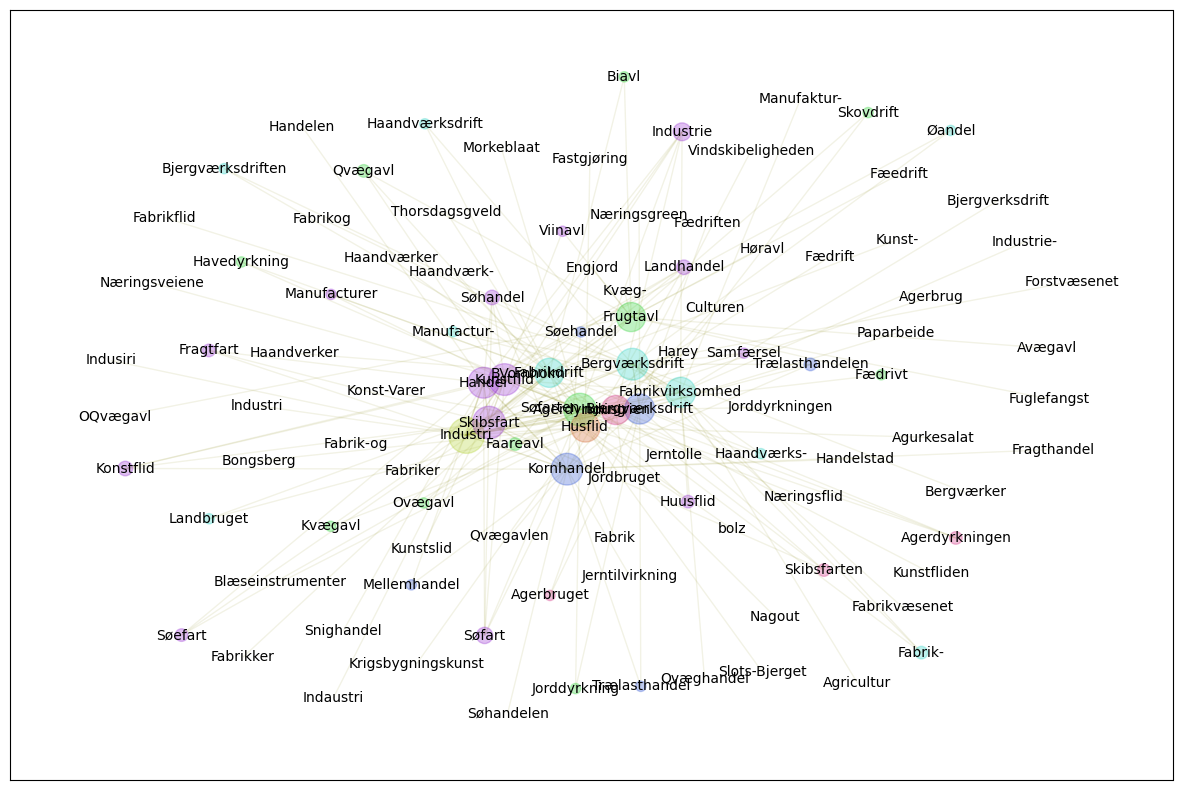

In [83]:
gnl.show_graph(G, spread=0.01)

In [84]:
G = graf('Industri', model=d,top=20)
(show_centralities(G, 20).fillna(0)
    .sort_values(by=['Degree','Indegree','Betweennes','Outdegree',], ascending=False)
    .style
    .background_gradient(axis = 1))

,Betweennes,Degree,Indegree,Outdegree
index,,,,
Industri,0.046855,0.205298,0.072848,0.132450
Agerdyrkning,0.004528,0.172185,0.039735,0.132450
Kornhandel,0.004423,0.172185,0.039735,0.132450
Kunstflid,0.003567,0.172185,0.039735,0.132450
Skibsfart,0.002800,0.172185,0.039735,0.132450
Søhandel,0.002753,0.165563,0.033113,0.132450
Bergværksdrift,0.006301,0.158940,0.026490,0.132450
Handel,0.002902,0.158940,0.026490,0.132450
Kvæg-,0.005647,0.145695,0.000000,0.132450


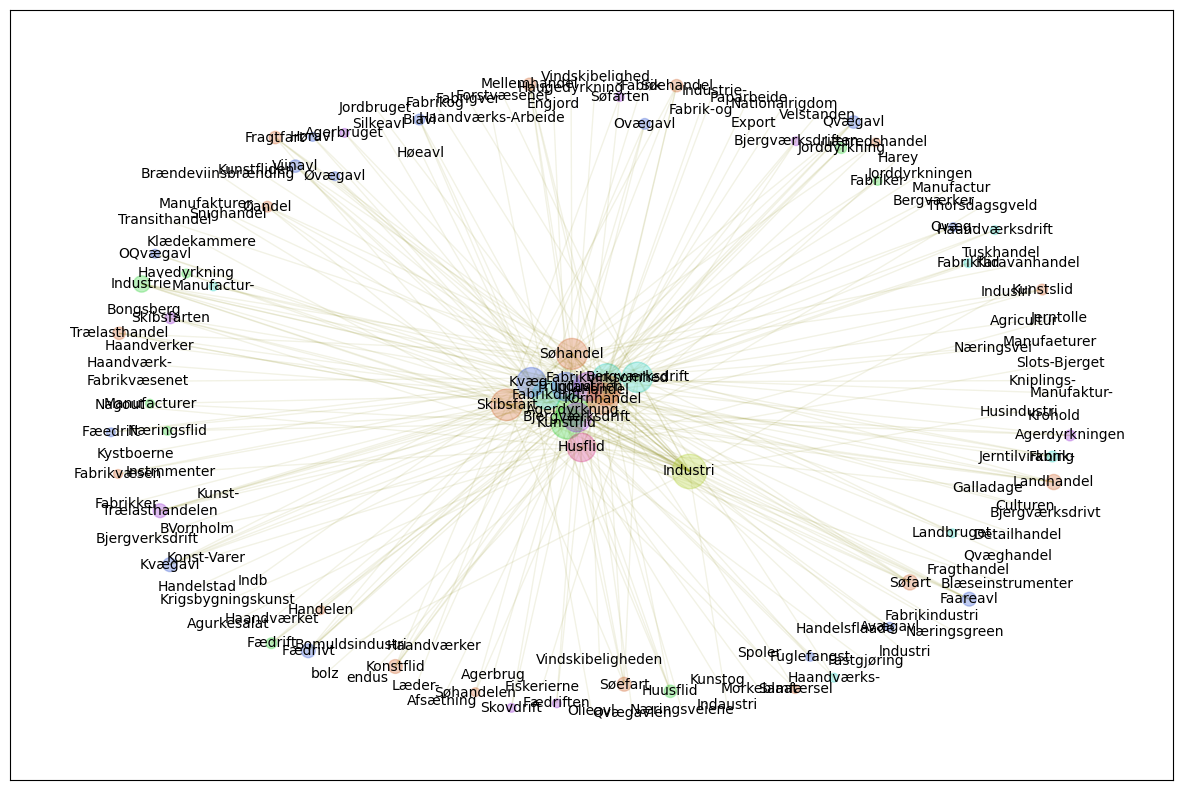

In [85]:
gnl.show_graph(G)

In [86]:
gnl.show_communities(G)

Industri-lndustri :  Industri, lndustri, Fabrikindustri, Bomuldsindustri, Indaustri, Husindustri, Indusiri

Agerdyrkning-Kunstflid :  Agerdyrkning, Kunstflid, Industrie, Huusflid, Jorddyrkning, Fædrift, Næringsflid, Fabriker, Havedyrkning, Manufacturer, Manufakturer, Agerbrug, Haugedyrkning, Vindskibelighed

Bergværksdrift-Fabrikvirksomhed :  Bergværksdrift, Fabrikvirksomhed, Fabrikdrift, Fabrik-, Haandværks-, Haandværksdrift, Manufactur-, Fabrikflid, Landbruget, Haandværket, Haandværker, Agricultur, Forstvæsenet, Kunstog, Industrie-, Manufaeturer, Haandværks-Arbeide, Fabrigver, Haandverker, Krohold, Manufaktur-, Kunst-, Bjergverksdrift, Fabrikog, Nationalrigdom, Qvæghandel, Haandværk-, Fabrik, Manufactur, Fabrikvæsenet, Fabrikker, Fiskerierne, Fabrik-og, Bergværker

Kvæg--Frugtavl :  Kvæg-, Frugtavl, Fædrivt, Faareavl, Kvægavl, Qvægavl, Viinavl, Biavl, Ovægavl, Øvægavl, OQvægavl, Høravl, Fuglefangst, Avægavl, Qvæg-, Fæedrift, Kystboerne, Læder-, Kniplings-, Bjergværksdrivt, Silkeavl, 